# DES	simulation	assignment
## Multiple queues and multiple servers


$\lambda$ – the arrival rate into the system as a whole. \
$\mu$ – the capacity of each of n equal servers. \
$\rho$ represents the system load. \
In a single server system, it will be: $\rho = \frac{\lambda}{\mu}$ \
In a multi-server system (one queue with n equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{(n \mu)}$

Queuing theory tells us that for FIFO scheduling the average waiting times are shorter for an
M/M/n queue and a system load ρ and processor capacity µ than for a single M/M/1 queue
with the same load characteristics (and thus an n-fold lower arrival rate). Of course, ρ must be
less than one, but the experiment only becomes interesting when ρ is not much less than one.

### 1) Look up and/or derive this theoretical result, at least for n=2. Describe how it is derived. Can you also give a non-mathematical explanation?

TODO

### 2) Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on ρ?

M/M/n: \
Markovian/memoryless inter-arrival time distribution, so draw from exponential distribution \
Markovian/memoryless service time distribution, so draw from exponential distribution \ 
n servers \
Infinite queue \
Service queuing disciple = FIFO


In [1]:
import numpy as np
import simpy
import matplotlib.pyplot as plt
from scipy.stats import t

In [9]:
def hyperexponential_2_phases(p_values = [0.75, 0.25], means = [1, 5]):
    '''Generates a single sample from a hyperexponential distribution.
    Input: p_values, list with probabilities for every phase, and means, list of means for every phase.
    Output: single sample from the hyperexponential distribution.
    '''
    if sum(p_values) != 1.0:
        raise ValueError("Probabilities must add up to 1!")
    
    choice_idx = np.random.choice(len(p_values), p=p_values)
    mean = means[choice_idx]
    
    return np.random.exponential(mean)

In [12]:
class MMNQueue:
    def __init__(self, env, n, rho, mu, scheduling='FIFO', service_distr = 'M'):
        self.env = env
        self.servers = [simpy.Resource(env) for _ in range(n)]
        self.mu = mu
        self.rho = rho
        self.lamda = rho*(n*mu)
        self.total_arrivals = 0
        self.total_complete_services = 0
        self.total_time_in_queue = 0
        self.arrival_times = []
        self.scheduling = scheduling
        self.service_distr = service_distr

    def arrival_process(self, num_customers):
        while self.total_arrivals < num_customers:
            yield self.env.timeout(np.random.exponential(1/self.lamda))
            self.total_arrivals += 1
            arrival_time = self.env.now
            self.arrival_times.append(arrival_time)
            self.env.process(self.service())

    def service(self):
        arrival_time = self.env.now

        if self.scheduling == 'FIFO':
            server = min(self.servers, key=lambda s: len(s.queue))
        elif self.scheduling == 'SJF':
            server = min(self.servers, key=lambda s: s.count)
        else:
            raise ValueError("Invalid Scheduling Method")

        with server.request() as req:
            yield req

            service_start_time = self.env.now
            
            if self.service_distr == 'M':
                service_time = np.random.exponential(1 / self.mu)
            elif self.service_distr == 'D':
                service_time = self.mu
            elif self.service_distr == 'H2':
                service_time = hyperexponential_2_phases()
            else:
                raise ValueError("Invalid Service Time Distribution")

            yield self.env.timeout(service_time)

            departure_time = self.env.now
            self.total_complete_services += 1

            # Calculate time spent in the queue
            time_in_queue = service_start_time - arrival_time
            self.total_time_in_queue += time_in_queue

    def run_simulation(self, num_customers):
        self.env.process(self.arrival_process(num_customers))
        self.env.run(until=float('inf')) 

In [4]:
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), np.std(data, ddof=1) / np.sqrt(n)
    h = se * t.ppf((1 + confidence) / 2, n - 1)
    return m, h

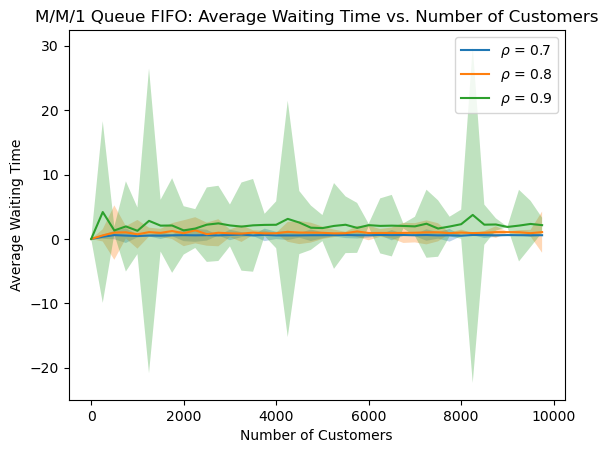

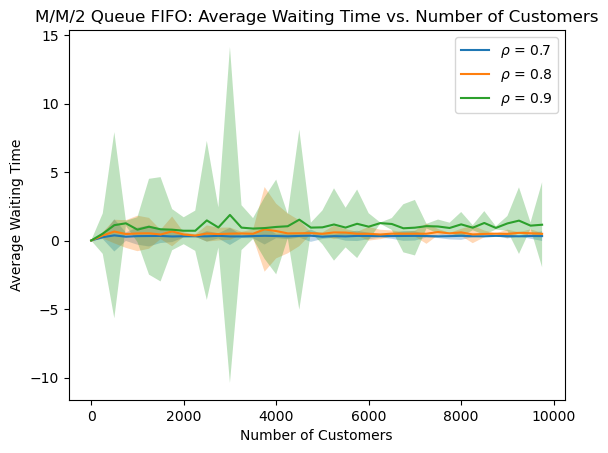

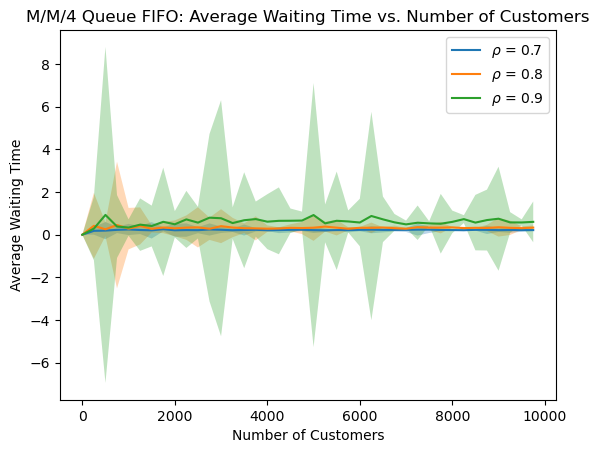

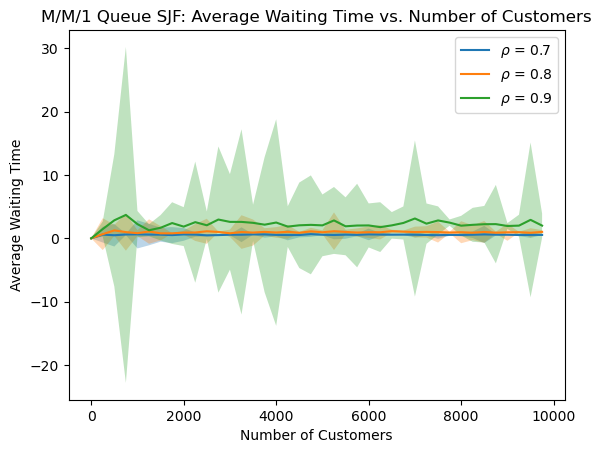

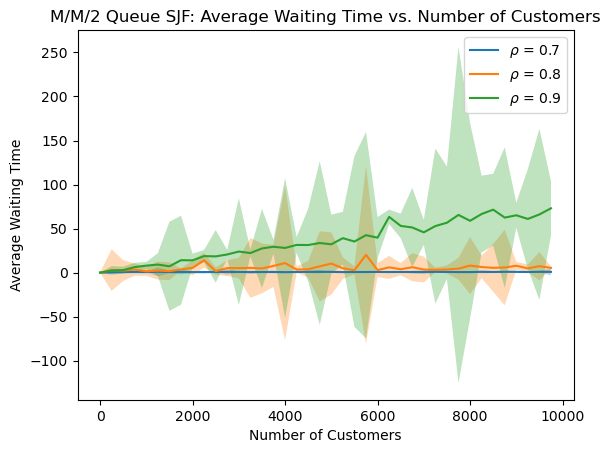

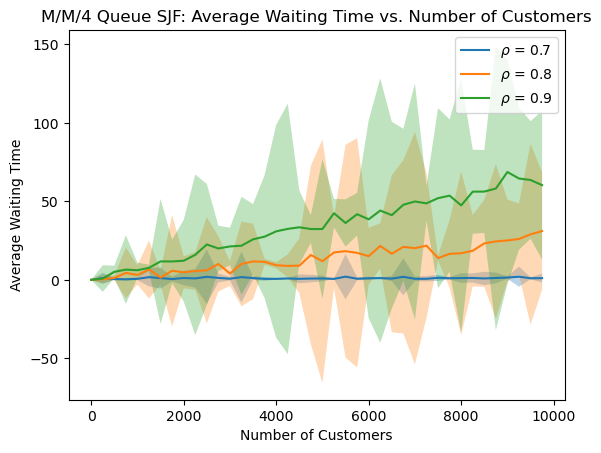

In [15]:
def main():
    num_simulations = 2
    num_customers_values = np.arange(0, 10000, 250)
    rhos = [0.7, 0.8, 0.9]
    mu = 4
    scheduling_policies = ['FIFO', 'SJF']

    for scheduling_policy in scheduling_policies:
        for n in [1, 2, 4]:
            plt.figure()
            plt.title(f'M/M/{n} Queue {scheduling_policy}: Average Waiting Time vs. Number of Customers')
            plt.xlabel('Number of Customers')
            plt.ylabel('Average Waiting Time')

            for rho in rhos:
                avg_waiting_times = []
                confidence_intervals = []

                for num_customers in num_customers_values:
                    simulation_results = []

                    for _ in range(num_simulations):
                        env = simpy.Environment()
                        mmn_queue = MMNQueue(env, n, rho, mu, scheduling_policy)
                        mmn_queue.run_simulation(num_customers)

                        if mmn_queue.total_complete_services > 0:
                            avg_waiting_time = mmn_queue.total_time_in_queue / mmn_queue.total_complete_services
                            simulation_results.append(avg_waiting_time)
                        else:
                            simulation_results.append(0)

                    avg_waiting_time, confidence_interval = calculate_confidence_interval(simulation_results)
                    avg_waiting_times.append(avg_waiting_time)
                    confidence_intervals.append(confidence_interval)

                # Plot the average waiting time
                plt.plot(num_customers_values, avg_waiting_times, label=f'$\\rho$ = {rho}')

                # Plot the shaded confidence interval
                plt.fill_between(num_customers_values,
                                np.array(avg_waiting_times) - np.array(confidence_intervals),
                                np.array(avg_waiting_times) + np.array(confidence_intervals),
                                alpha=0.3)

            plt.legend()
            plt.show()

if __name__ == "__main__":
    main()

# SJF vs. FIFO

# Different Service Rate distributions

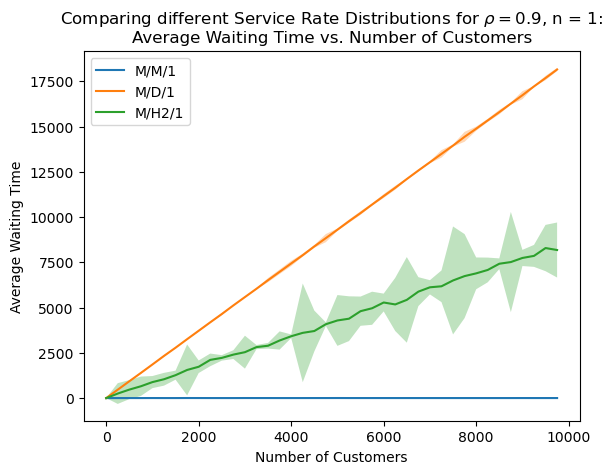

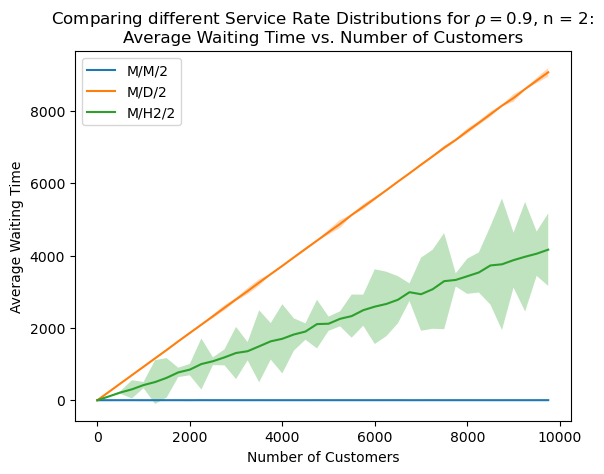

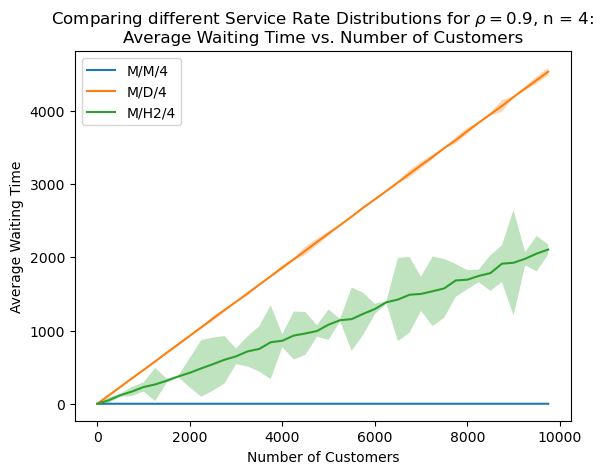

In [17]:
def service_rate_comparisons():
    num_simulations = 2
    num_customers_values = np.arange(0, 10000, 250)
    rho = 0.9
    mu = 4
    service_distributions = ['M', 'D', 'H2'] #Exponential, Deterministic, Hyper-2

    
    for n in [1, 2, 4]:
        
        plt.figure()
        plt.title(f'Comparing different Service Rate Distributions for $\\rho = {rho}$, n = {n}:\nAverage Waiting Time vs. Number of Customers')
        plt.xlabel('Number of Customers')
        plt.ylabel('Average Waiting Time')

        for service_distr in service_distributions:

            avg_waiting_times = []
            confidence_intervals = []

            for num_customers in num_customers_values:
                simulation_results = []

                for _ in range(num_simulations):
                    env = simpy.Environment()
                    mmn_queue = MMNQueue(env, n, rho, mu, service_distr = service_distr)
                    mmn_queue.run_simulation(num_customers)

                    if mmn_queue.total_complete_services > 0:
                        avg_waiting_time = mmn_queue.total_time_in_queue / mmn_queue.total_complete_services
                        simulation_results.append(avg_waiting_time)
                    else:
                        simulation_results.append(0)

                avg_waiting_time, confidence_interval = calculate_confidence_interval(simulation_results)
                avg_waiting_times.append(avg_waiting_time)
                confidence_intervals.append(confidence_interval)

            # Plot the average waiting time
            plt.plot(num_customers_values, avg_waiting_times, label=f'M/{service_distr}/{n}')

            # Plot the shaded confidence interval
            plt.fill_between(num_customers_values,
                            np.array(avg_waiting_times) - np.array(confidence_intervals),
                            np.array(avg_waiting_times) + np.array(confidence_intervals),
                            alpha=0.3)
            
        plt.legend()
        plt.show()

service_rate_comparisons()